# 0. Set the Google Colab runtime

To benefit from the GPU resources offered by Google, in the menu above go to _Runtime_ > _Change runtime type_ and select the T4 GPU hardware accelerator. Then run the cell below to install the GPU version of the DiaBayes code.

In [ ]:
!pip install "git+https://github.com/martijnende/diabayes.git#egg=diabayes[gpu]"

In [2]:
import jax.numpy as jnp
import matplotlib.pyplot as plt

import diabayes as db
from diabayes.forward_models import Forward, rsf, ageing_law, springblock
from diabayes.solver import ODESolver

In this example, we will be running a simple forward simulation of a non-inertial spring-block governed by classical rate-and-state friction (RSF). The forward simulation serves as a set of "friction observations" that we will then invert for the rate-and-state parameters ($a,b,D_c$). If everything goes well, the inverted parameters are identical to the ones we started with.

## 1. Forward modelling

First we define the RSF and spring-block parameters, and assume that we start at steady-state:

In [3]:
# RSF parameters
a = 0.01
b = 0.9 * a
Dc = 1e-5

# Spring-block parameters: stiffness, initial velocity, final velocity
k = 1e3
v0 = 1e-6
v1 = 1e-5

# Initial friction and state
mu0 = 0.6
theta0 = Dc / v0

Next, we describe our forward model, which is composed of a friction law (classical RSF), a state evolution law (ageing law), and the stress transfer model (non-inertial spring-block). We also define the solver, which includes both the forward and inverse solver routines.

In [4]:
state_dict = {"theta": ageing_law}
forward = Forward(friction_model=rsf, state_evolution=state_dict, stress_transfer=springblock)
solver = ODESolver(forward_model=forward)

The last step before running a forward simulation, is to pack all of the parameters and initial conditions into appropriate "containers". These containers act like `namedtuple`s; you can initialise one by providing the parameters in the right order, or as keyword arguments (for example, `params = db.RSFParams(a, b, Dc)` returns the same as `params = db.RSFParams(Dc=Dc, a=a, b=b)`). You can access individual entries by their name, e.g. `b = params.b`. 

Setting variables (i.e., the quantities that change over time) works similarly, but the structure of their container depends on the physics that was provided to the `Forward` class. Fortunately, this is handled automatically by providing the appropriate initial values to the `Forward` class object.

In [ ]:
# RSF parameters
params = db.RSFParams(a=a, b=b, Dc=Dc)
# RSF constants
constants = db.RSFConstants(v0=v0, mu0=mu0)
# Spring-block constants
block_constants = db.SpringBlockConstants(k=k, v_lp=v1)

# Initial values of friction and state
forward.set_initial_values(mu=mu0, theta=theta0)
y0 = forward.variables

# The time samples for which we want a solution
t = jnp.linspace(0, 15., 1000)

# Run the forward simulation
result = solver.solve_forward(
    t, y0, params=params,
    friction_constants=constants,
    block_constants=block_constants
)

The result of this forward simulation (`result`) is a `db.Variables` object similar to `y0` defined above. Hence the friction and state can be accessed as `result.ys.mu` and `result.ys.theta`:

Text(0.5, 0, 'time [s]')

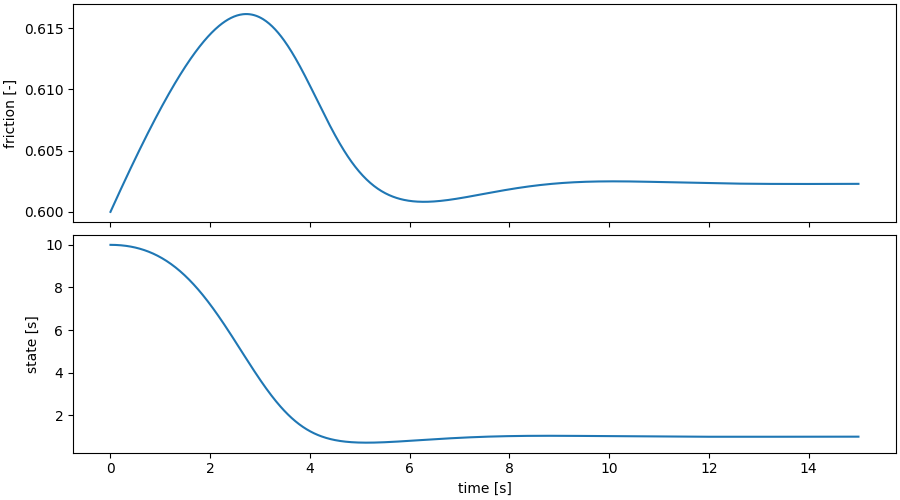

In [6]:
mu = result.mu
theta = result.theta

plt.close("all")
fig, axes = plt.subplots(nrows=2, figsize=(9, 5), constrained_layout=True, sharex="all")
axes[0].plot(t, mu)
axes[0].set_ylabel("friction [-]")
axes[1].plot(t, theta)
axes[1].set_ylabel("state [s]")
axes[1].set_xlabel("time [s]")

## 2. Maximum-likelihood inversion

Now that we have some "measurements" of a friction coefficient, we can try to invert for the underlying parameters that govern the dynamics. For this particular toy example it is not super useful to invert for the parameters that you already know, but in reality you would replace `mu` with your laboratory measurements, for which the RSF parameters are not known.

To start simple, we begin with a _maximum-likelihood_ inversion, which tries to find a (local) minimum in the misfit between the measured and predicted friction values. The parameters that correspond with the best fit may not be unique (there could be multiple combinations of parameters that yield the same misfit), and this kind of inversion does not offer a good sense of the uncertainties and trade-offs in the inverted parameters. For this we'd need to do a _Bayesian inversion_, which will come a bit later. Regardless, the maximum likelihood inversion gives us a good starting point, and might already be sufficient for some applications.

In the cell below, we generate simulate noisy measurements by adding some Gaussian noise to the friction curve obtained above. We also define an initial guess of the RSF parameters that is a bit different from the true parameter values, which in practice is likely to be the case.

In [7]:
import jax.random as jr

# The JAX random number generator
key = jr.PRNGKey(42)
key, split_key = jr.split(key)
noise = jr.normal(split_key, shape=(len(t),))

# You can play around with the noise amplitude to make
# the inversion more or less challenging...
noise_amplitude = 1e-3

mu_measured = mu + noise * noise_amplitude

# Initial guess of the parameters
params_guess = db.RSFParams(
    a = 1.1 * a,
    b = 1.2 * b,
    Dc = 2 * Dc
)

# Do the maximum-likelihood inversion
# Set verbose=True to get intermediate messages
# of the solver progress
inv_result = solver.max_likelihood_inversion(
    t, mu_measured, y0,
    params=params_guess,
    friction_constants=constants,
    block_constants=block_constants,
    verbose=True
)

Step: 0, Loss on this step: 0.0031062619344770495
Step: 1, Loss on this step: 0.0014327439927960947
Step: 2, Loss on this step: 0.0005079012385201731
Step: 3, Loss on this step: 0.0004554938162316278
Step: 4, Loss on this step: 0.00045494831074373895
Step: 5, Loss on this step: 0.0004549482405273416


The result of the inversion (`inv_result`) is an [`optimistix.Solution`](https://docs.kidger.site/optimistix/api/solution/#optimistix.Solution) object, similar to the `diffrax.Solution` object we've seen before. The inverted parameters are accessed through `inv_result.value`, which contains a `RSFParams` object.

We can get these parameters and run another forward simulation to see if we obtained an acceptable fit with the data:

Inverted parameters: RSFParams(a=f64[], b=f64[], Dc=f64[])
True parameters: RSFParams(a=weak_f64[], b=weak_f64[], Dc=weak_f64[])


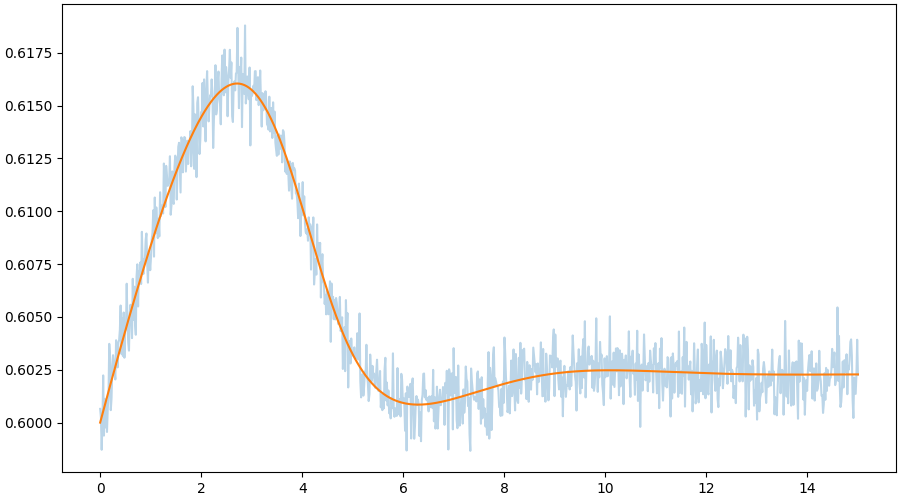

In [8]:
params_inv = inv_result.value

result_predicted = solver.solve_forward(t, y0, params_inv, constants, block_constants)

print(f"Inverted parameters: {params_inv}")
print(f"True parameters: {params}")

plt.close("all")
fig, ax = plt.subplots(figsize=(9, 5), constrained_layout=True)
ax.plot(t, mu_measured, alpha=0.3)
ax.plot(t, result_predicted.mu)

As you can see, even with a substantial noise level we were able to recover the true parameters. We can do the inversion again with a different initial guess to see how much this starting point affects the solver convergence:

In [9]:
params_guess2 = db.RSFParams(
    a = 0.9 * a,
    b = 0.7 * b,
    Dc = 1.5 * Dc
)

inv_result2 = solver.max_likelihood_inversion(
    t, mu_measured, y0,
    params=params_guess2,
    friction_constants=constants,
    block_constants=block_constants,
    verbose=True
)

params_inv2 = inv_result2.value
result_predicted2 = solver.solve_forward(t, y0, params_inv2, constants, block_constants)

Step: 0, Loss on this step: 0.00879827890106592
Step: 1, Loss on this step: 0.005383346705836939
Step: 2, Loss on this step: 0.0027221340210401073
Step: 3, Loss on this step: 0.000758265066812316
Step: 4, Loss on this step: 0.0004587632593394646
Step: 5, Loss on this step: 0.00045495330751144526
Step: 6, Loss on this step: 0.00045494824098784334


Visual inspection of the results:

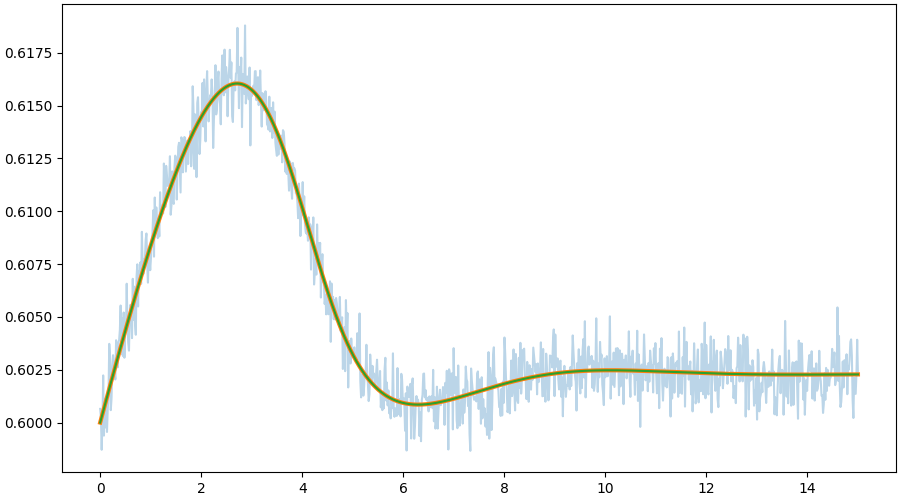

In [11]:
plt.close("all")
fig, ax = plt.subplots(figsize=(9, 5), constrained_layout=True)
ax.plot(t, mu_measured, alpha=0.3)
ax.plot(t, result_predicted.mu, lw=3)
ax.plot(t, result_predicted2.mu)

Quantitative comparison:

In [12]:
print("\t\tInitial guess 1\tInversion 1\tInitial guess 2\tInversion 2\tTrue values")
print(f"a\t\t{params_guess.a:.2e}\t{params_inv.a:.2e}\t{params_guess2.a:.2e}\t{params_inv2.a:.2e}\t{params.a:.2e}")
print(f"b\t\t{params_guess.b:.2e}\t{params_inv.b:.2e}\t{params_guess2.b:.2e}\t{params_inv2.b:.2e}\t{params.b:.2e}")
print(f"Dc\t\t{params_guess.Dc:.2e}\t{params_inv.Dc:.2e}\t{params_guess2.Dc:.2e}\t{params_inv2.Dc:.2e}\t{params.Dc:.2e}")

		Initial guess 1	Inversion 1	Initial guess 2	Inversion 2	True values
a		1.10e-02	9.93e-03	9.00e-03	9.93e-03	1.00e-02
b		1.08e-02	8.94e-03	6.30e-03	8.94e-03	9.00e-03
Dc		2.00e-05	1.00e-05	1.50e-05	1.00e-05	1.00e-05


As you can see, the inversion for both initial guesses converged to the same final result. This is not a given, and results may vary depending on the level of noise and other factors, like slip weakening or other phenomena that are not accounted for by the friction model.

You can also see that the inverted parameters are not exactly the same as those that we started with. Because of the influence of the noise, this is not unexpected. But how "good" are the inverted results? Is the ~10% mismatch between the inversion and the ground truth acceptable, given the level of noise that we have? In other words, does the ground truth fall within the uncertainty of the inversion estimate? And are there other combinations of parameters that would also produce an acceptable fit to the observations?

These are the kind of questions that can be answered with Bayesian inversion.

## 3. Bayesian inversion

Bayesian inversion methods acknowledge that our data are affected by noise, and that our models are not perfect. Hence, instead of looking for a single set of parameters that can describe the measurements, we will be calculating the probability that a given set of parameters describes the observations. By randomly sampling from a _prior distribution_ of parameters, we can approximate the _posterior distribution_ of the parameters given the observations.

There are numerous Bayesian sampling methods out there, each with their own performance characteristics in terms of computational cost, stability, and accuracy. A particularly suitable method for friction curve inversion is a particle-based method called _Stein Variational Inference_ (SVI). The basic outline of this method, is that each particle represents a set of model parameters, and that the collection of particles can move around in this parameter space. The particles are attracted towards the peak of the maximum-likelihood (the parameters that we inverted above), but they are also attracted towards the peak of the prior distribution, and they mutually repel one another based on their inter-particle distance. By iteratively updating the particle positions using gradient descent, the collection of particles eventually settles down into an equilibrium state. This equilibrium state is the posterior probability distribution over the inverted parameters.

All of the mathematics and numerical operations that come with SVI are swept under a rug that can be called with `solver.bayesian_inversion`. This routine takes the following inputs:

- `t`: the time at which the measurements are sampled
- `mu`: the friction measurements
- `noise_std`: an estimate of the standard deviation of the friction noise. Note that a larger value will permit a wider range of parameter values. Empirically, dividing the noise amplitude by 2 gives somewhat more acceptable results.
- `y0`: the initial values of the variables (friction, state, ...)
- `params`: the maximum-likelihood parameter values (obtained from the inversion above)
- `friction_constants`, `block_constants`: the constant parameters that will not be inverted for
- `Nparticles`: the number of particles in the swarm. A higher number gives more robust statistics, at the expense of a higher computational cost (though this doesn't scale proportionally due to significant GPU/CPU transmission overhead etc.). A minimum value around 1000 is recommended.
- `Nsteps`: the number of gradient descent steps to take. This number should be large enough to achieve a (quasi-)equilibrium. We will explore this in more detail later.
- `rng`: a random seed or a `jax.random.PRNGKey` (or `None`) to control the random initial state of the particle swarm. If `None`, the initialisation will be different every time you run the inversion, so it is recommended to fix the random seed to ensure reproducibililty.

On a modest GPU, the Bayesian sampling with the parameters below takes around 1-2 minutes. Part of this time is spent doing the JIT compilation, so a second run would likely be a little bit faster.

In [13]:
bayesian_result = solver.bayesian_inversion(
    t=t, mu=mu_measured, noise_std=noise_amplitude * 0.5, 
    y0=y0, params=params_inv, friction_constants=constants, 
    block_constants=block_constants, 
    Nparticles=1500, Nsteps=100, rng=42
)

print(bayesian_result)

Running for 100 iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Bayesian inversion results
------------------------------------------------------------

Number of particles:	1500
Number of iterations:	100
Number of parameters:	3 ('a', 'b', 'Dc')

		a		b		Dc
mean		9.83e-03	8.82e-03	1.02e-05
median		9.84e-03	8.82e-03	1.01e-05
std		6.24e-04	7.02e-04	1.33e-06
q5		8.79e-03	7.67e-03	8.22e-06
q95		1.08e-02	9.99e-03	1.26e-05

------------------------------------------------------------


The output of `bayesian_inversion` is a `BayesianSolution` object that holds the evolution of the particle swarm positions, their final state, diagnostic information, and first-order statistics (mean, median, etc.). The `BayesianSolution` class also implements a number of convenience routines for visualising and verifying the results.

First, let's have a look at the convergence of the particle swarm. Upon successful convergence, the particles should have become stationary, so if we plot the evolution of each particle over "time", we should be seeing them reaching a plateau. The log-likelihood estimation should also reach a plateau. We can plot these quantities using the `BayesianSolution.plot_convergence` routine:

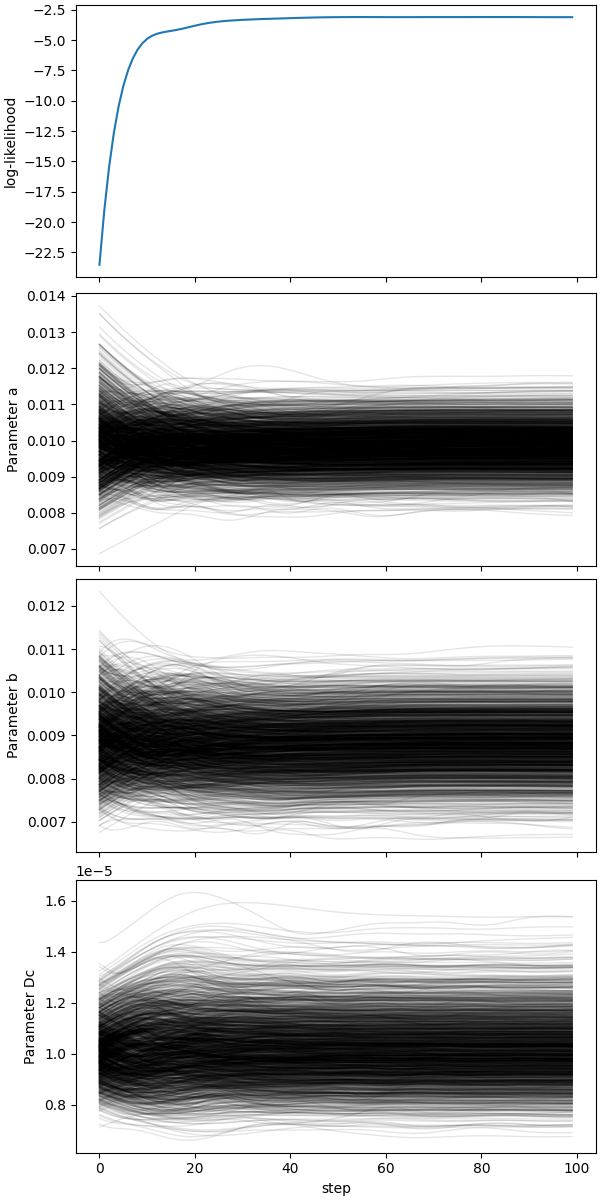

In [14]:
bayesian_result.plot_convergence();

This seems to be ok. Next, we can visualise the parameter posterior distributions in a _corner plot_ representation. In this representation, each parameter is plotted against the other parameters, which gives you a sense of the trade-offs between them. The error bars in each panel indicate the median and the 5/95th percentile range for each parameter, although these summary statistics may not necessarily be representative for all parameter combinations. The diagonal of the corner plot is populated with histrograms of a given parameter.

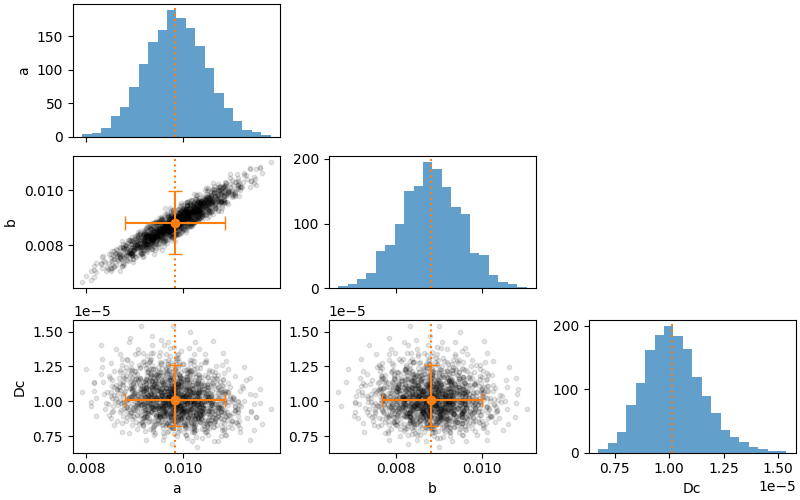

In [15]:
bayesian_result.cornerplot(nbins=20);

Lastly, we can draw a few samples from the particle swarm and compare the resulting friction curves with the measurements. For an appropriate choice of `noise_amplitude` (as provided to `solver.bayesian_inversion`), most of the predicted friction curves should match reasonably well with the observations (within the level of the noise). If the predictions don't follow the observations well enough, then perhaps `noise_amplitude` was over-estimated.

Text(0, 0.5, 'Friction [-]')

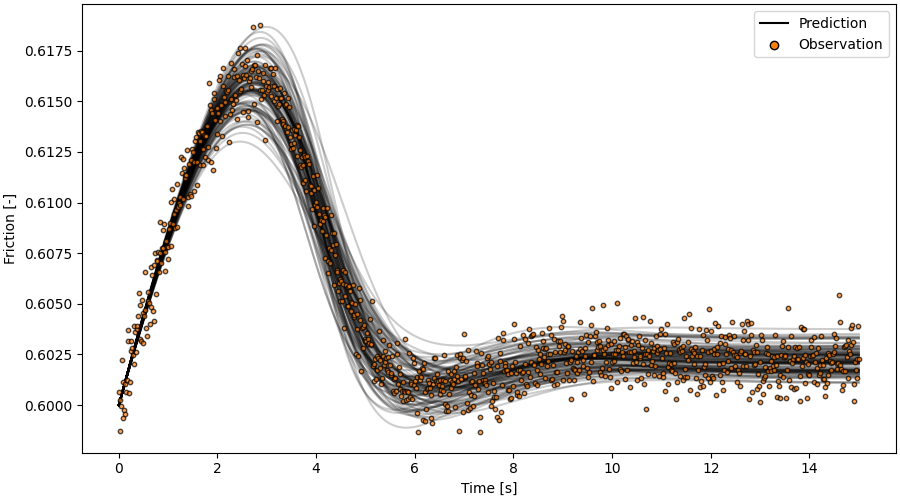

In [17]:
samples, sample_results = bayesian_result.sample(solver, y0, t, constants, block_constants, nsamples=100)

plt.close("all")
fig, ax = plt.subplots(figsize=(9, 5), constrained_layout=True)
ax.plot(t, jnp.squeeze(sample_results.mu).T, c="k", alpha=0.2)
ax.scatter(t, mu_measured, c="C1", s=10, zorder=len(samples) + 1, ec="k", lw=1, alpha=0.7)
ax.plot([], [], c="k", label="Prediction")
ax.scatter([], [], c="C1", ec="k", lw=1, label="Observation")
ax.legend()
ax.set_xlabel("Time [s]")
ax.set_ylabel("Friction [-]")